## Dimensionality Reduction

This notebook assumes that you have read through Jake Vanderplas' notebook on [dimensionality reduction](https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/04.1-Dimensionality-PCA.ipynb).  Here, we will expand on some of the ideas presented in the notebook.  First, we'll drill down into the underlying mathematics of principal components analysis (PCA), we'll apply PCA to some non-digit data (gasp), and then we'll move to non-linear dimensionality reduction.

Suppose we have a dataset of $x_1, x_2, \ldots, x_n$ with each $x_i \in \mathbb{R}^d$.  We'd like to find the most "important dimensions" in the data.  Here are some criteria that we can use to operationalize this notion of importance:
1.  Compress the data to a fixed size while preserving as much information as possible.
2.  Maximize the variance of the data when projected into this reduced space.

For the case of linear dimensionality reduction, it turns out these two notions are equivalent.

### Linear Dimensionality Reduction

First, let's make the problem a little simpler.  Let's consider the case where the mean of the dataset for each of the d-dimensions is zero.  We can accomplish this by simply computing the mean across all of the points $x_1, \ldots, x_n$ and then subtracting the mean from each point to create a new, zero-mean dataset.

Let's consider the task of reducing our dataset to a single number for each data point.  Specifically, we will consider schemes that project all datapoints onto a vector $v$.

One way to think of our goal is that we'd like to choose a $v$ that preserves as much of the original information in the data as possible.  A sensible way to define this preservation of information is to look at the squared error between the projection onto $v$ and the original data point.  The projection of a point onto a vector $v$ can be understood geometrically using this picture (source [Wikipedia entry on Vector Projection](https://en.wikipedia.org/wiki/Vector_projection)).
![vector projection](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/Dot_Product.svg/300px-Dot_Product.svg.png)

This is starting to shape up, but we don't know what $\theta$ is.  In order to do this we will have to apply the following fact about dot products.

$$a \cdot b = |a| |b| \cos \theta $$

Therefore, $cos \theta = \frac{a \cdot b}{|a||b|}$.  From our picture above, we know that the vector we'd like to compute is $B |A| \cos \theta$.  Another way to write the dot-product of $A$ and $B$ is as a vector-vector multiplication: $A^\top B$.  Substituing in our formula for $\cos \theta$ yields:

$$\begin{align}
B |A| \cos \theta &= B |A| \frac{A^\top B}{|A||B|} \\
&= B \frac{A^\top B}{|B|} \\
&= B \frac{B^\top A}{|B|}, \mbox{note: dot product is commutative}
\end{align}$$

Therefore, we can define the squared error for a particular choice of $v$ as:

$$\left |v \frac{v^\top x_i}{|v|}- x_i \right|^2 \enspace .$$

One thing that is clear is that the magnitude of $v$ doesn't really have any effect on the reconstruction error.  Therefore, we can restrict ourselves to looking for vectors $v$ that are unit vectors.  This simplifies our formula for the reconstruction error to:

$$\left | v v^\top x_i - x_i \right|^2 \enspace .$$

The squared magnitude of a vector, $|u|^2$, can be computed as $u^\top u$.  We can now write the reconstruction error as:

$$\left ( v v^\top  x_i - x_i \right )^\top \left ( v v^\top  x_i - x_i \right )$$
$$ =x_i^\top v v^\top v v^\top x_i - 2x_i^\top v v^\top x_i + x_i^\top x_i$$

Since $v$ is a unit vector, $v^\top v = 1$.  Our reconstrution can be further simplied to:

$$\begin{align}
&= x_i^\top v v^\top x_i - 2x_i^\top v v^\top x_i + x_i^\top x_i \\
&= - x_i^\top v v^\top x_i + x_i^\top x_i
\end{align} \enspace .$$

Making use of the commutative property for dot products ($a^\top b = b^\top a$).  We have:

$$ = - v^\top x_i x_i^\top v + x_i^\top x_i$$

The cumulative squared error over the whole dataset is given as:

$$\begin{align}
error(v) &= \sum_{i=1}^n \left ( x_i^\top x_i - v^\top x_i x_i^\top v \right ) \\
&= \sum_{i=1}^n  x_i^\top x_i  - \sum_{i=1}^n v^\top x_i x_i^\top v \\
&= \sum_{i=1}^n  x_i^\top x_i  - v^\top \left (\sum_{i=1}^n  x_i x_i^\top \right ) v
\end{align}$$

We are interested in the vector $v$ that minimizes our error function:

$$\begin{align}
v^\star &= \arg\min_v error(v) \\
&= \arg\min_v \sum_{i=1}^n  x_i^\top x_i  - v^\top \left (\sum_{i=1}^n  x_i x_i^\top \right ) v \\
 &= \arg\min_v- v^\top \left (\sum_{i=1}^n  x_i x_i^\top \right ) v \\
&= \arg\max_v v^\top \left (\sum_{i=1}^n  x_i x_i^\top \right ) v 
\end{align}$$

The last equation is simply the definition of the maximum Eigenvalue of the matrix $\left (\sum_{i=1}^n  x_i x_i^\top \right )$ (also known as the [Rayleigh coefficient](https://en.wikipedia.org/wiki/Rayleigh_quotient)).  The maximum Eigenvalue of this matrix can be computed easily using a numerical solver.  This gives us the first principal component.  If you want more principal components, you simply subtract out the reconstruction of the original data using the first principal component and repeat the procedure defined above on this transformed data.

### Eigenfaces

One of the most widely used examples of PCA is as applied to faces.  This is the so-called "Eigenfaces" algorithm.  The approach is so widely used since it has a computational benefit, faces can be represented with just a few numbers, and it has the ability to isolate potentially uninteresting factors such as lighting conditions.

I will show an example of this applied to the smile dataset that we saw way back in the bottom-up machine learning portion of the course.

In [30]:
import sys
sys.path.append('../day06')
from load_smiles import load_smiles
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# load the data
data = load_smiles()
X, y = data.data, data.target

# make the data mean-zero
scaler = StandardScaler(with_std=False)
X_mean_zero = scaler.fit_transform(X)

# verify that the standard scalar did its job
print "data shape", X_mean_zero.shape
print "pixel means", X_mean_zero.mean(axis=0)

# compute first 36 Eigenfaces from our dataset
pca = PCA(n_components=36)
transformed = pca.fit_transform(X_mean_zero)

 data shape (20185, 576)
pixel means [  2.62251344e-17   1.53126624e-17  -1.26725482e-17   5.98425886e-18
  -4.82260861e-17   1.82167880e-17  -1.39486034e-17   5.38913312e-17
   7.70033309e-19   4.76320604e-17  -5.04261813e-17  -7.66513157e-17
   8.44836545e-18  -2.72811801e-18  -1.32005710e-17   1.83927956e-17
   3.50255151e-17   1.76007614e-18  -1.51366548e-17   4.10097739e-17
   1.11588827e-16   1.03844492e-17  -1.54886700e-17  -4.92821318e-18
   9.06439210e-18   3.90736902e-17   7.40112015e-17  -9.54841303e-18
  -6.46827980e-18   5.94025696e-18   5.83905258e-17  -1.73367499e-17
  -8.53636926e-17  -5.06901927e-17  -1.00324340e-17  -2.43770545e-17
  -4.08337663e-17  -7.04030454e-19  -1.34645824e-17   2.91292600e-17
  -1.96248489e-17   2.34090126e-17  -1.83047918e-17  -1.93608375e-18
  -3.34414466e-17   1.23205329e-17   1.46086319e-17  -1.47846395e-17
   1.58406852e-18   5.57944135e-17  -5.65864477e-17   4.20218177e-17
   3.54655341e-17  -1.97568546e-17  -3.37934618e-17  -4.08337663e-

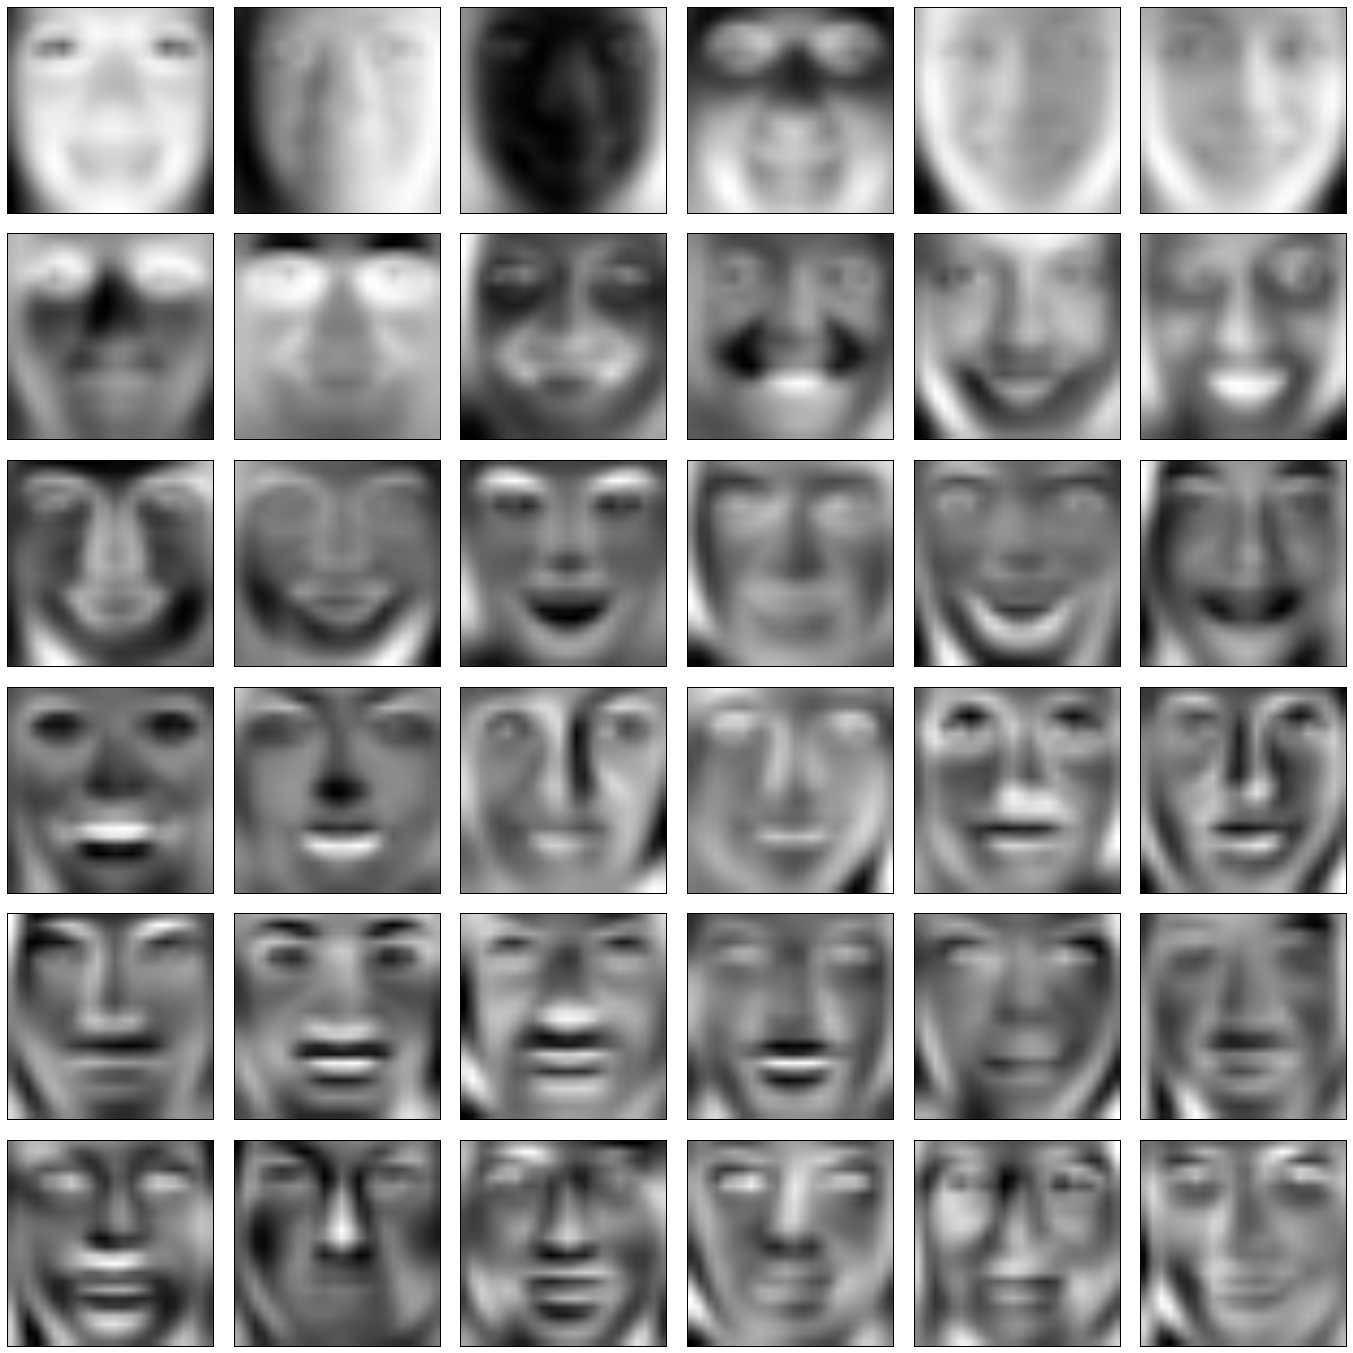

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_images(images):
    """ Adapted from Jake Vanderplas' scikit learn tutorials. """
    fig, axes = plt.subplots(6, 6, figsize=(24, 24))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i,:].reshape((24,24)).T, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

show_images(pca.components_)

These principal components, "Eigenface", represent the best possible linear compression of the face database into just 36 numbers.  At a high-level they seem to capture things like lighting, pose, and facial expression.  It's possible that these faces would make for a more robust representation of a face for things like facial expression recognition and face identity recognition.

### Non-negative Matrix Factorization

Another way to reduce the dimensionality of data is to apply non-negative matrix factorization.  This is very similar to PCA except all of the coefficients and all of the basis vectors must be positive.  This forces the effect of each component to be additive.  This has the effect of the algorithm focusing on extracting parts of objects rather than global effects as we see in PCA.

For an overview of the algorithm and some cool figures see [this](http://www.columbia.edu/~jwp2128/Teaching/W4721/papers/nmf_nature.pdf) paper.

In [45]:
# warning... This code seems to be too slow to run in a reasonable
# length of time.  We'll just jump right to the punchline by looking
# at the paper.

from sklearn.decomposition.nmf import NMF

decomp = NMF()
transformed = decomp.fit_transform(X)
show_images(decomp.components_)

KeyboardInterrupt: 

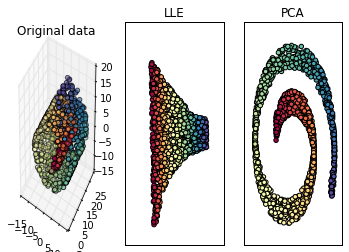

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# This import is needed to modify the way figure behaves
from mpl_toolkits.mplot3d import Axes3D
Axes3D

from sklearn import manifold, datasets

X, color = datasets.samples_generator.make_swiss_roll(n_samples=1500)
X_r, err = manifold.locally_linear_embedding(X, n_neighbors=12,
                                             n_components=2)
X_pca = PCA(n_components=2).fit_transform(X)

#----------------------------------------------------------------------
# Plot result

fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(132)
ax.scatter(X_r[:, 0], X_r[:, 1], c=color, cmap=plt.cm.Spectral)
plt.xticks([]), plt.yticks([])
ax.set_title('LLE')

ax = fig.add_subplot(133)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=color, cmap=plt.cm.Spectral)
plt.xticks([]), plt.yticks([])
ax.set_title('PCA')

plt.show()

Dimensionality reduction is a very large field.  Check out [this](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) great paper that describes one of the most promising new approaches (conveniently built into sklearn), and also surveys a bunch of older ones.